In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

batch_size = 10**3
Z_dim = 10
# Extended MNIST Dataset
train_dataset = datasets.EMNIST(root='./emnist_data/', split= 'byclass', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.EMNIST(root='./emnist_data/', split= 'byclass', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=Z_dim)
if torch.cuda.is_available():
    vae.cuda()
    model = vae.to('cuda')
    print('cuda')

cuda


In [3]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=10, bias=True)
  (fc32): Linear(in_features=256, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [4]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [5]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [6]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [7]:
num_epochs = 500
for epoch in range(0, num_epochs):
    train(epoch)
    test()

Train Epoch: 0 [0/697932 (0%)]	Loss: 545.294813
Train Epoch: 0 [100000/697932 (14%)]	Loss: 246.911891
Train Epoch: 0 [200000/697932 (29%)]	Loss: 209.786125
Train Epoch: 0 [300000/697932 (43%)]	Loss: 183.399391
Train Epoch: 0 [400000/697932 (57%)]	Loss: 176.643594
Train Epoch: 0 [500000/697932 (72%)]	Loss: 174.316750
Train Epoch: 0 [600000/697932 (86%)]	Loss: 166.943187
====> Epoch: 0 Average loss: 200.2486
====> Test set loss: 165.3917
Train Epoch: 1 [0/697932 (0%)]	Loss: 165.851828
Train Epoch: 1 [100000/697932 (14%)]	Loss: 165.746656
Train Epoch: 1 [200000/697932 (29%)]	Loss: 161.329875
Train Epoch: 1 [300000/697932 (43%)]	Loss: 160.009062
Train Epoch: 1 [400000/697932 (57%)]	Loss: 157.065812
Train Epoch: 1 [500000/697932 (72%)]	Loss: 160.393266
Train Epoch: 1 [600000/697932 (86%)]	Loss: 156.700437
====> Epoch: 1 Average loss: 160.0402
====> Test set loss: 156.7404
Train Epoch: 2 [0/697932 (0%)]	Loss: 153.672125
Train Epoch: 2 [100000/697932 (14%)]	Loss: 156.642469
Train Epoch: 2 [20

In [8]:
torch.save(vae,'./trained_models/latest_model_500_epochs_ltsp_10.pt')

In [9]:
#Capital A label is 10
#lower case a label is 36
def all_test_images_indexes_for_label(target_label):
    indexes = []
    for index in range(len(test_dataset)): 
        image, label = test_dataset[index]
        if label == target_label:
            indexes.append(index)
    return indexes

def master_image_label_map():
    master_label = []
    for index in range(len(test_dataset)): 
        image, label = test_dataset[index]
        master_label.append(label)
    return master_label



In [10]:
Label_Map = master_image_label_map()
print(Label_Map[79:85])

[40, 32, 4, 8, 2, 1]


In [11]:
labels_to_indexes = {}
for label in range(62):
    labels_to_indexes[label] = [index for index in range(len(Label_Map)) if Label_Map[index]==label]
    print(label)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


In [12]:
def mean_latent_space_vector(Indexes):
    total_sample = torch.zeros(Z_dim).cuda()
    for index in Indexes:
        test_image_A, test_target_A = test_dataset[index]

        #Shape input into what the network wants
        z = torch.flatten(test_image_A)
        z = torch.tensor(z)
        z = z.cuda()

        #Map through the model to the latent space 
        latent_sample =  vae.encoder(z)[0]
        total_sample = torch.add(latent_sample, total_sample)
    
    return total_sample/len(Indexes)


In [13]:
#Generate dict of the mean differences between lowercase and uppercase letters one at a time
#uses indexes of the capital letters
lower_to_upper_dict = {}
Upper_means = {}
Lower_means = {}

for offset in range(26):
    A_indexes = labels_to_indexes[10 + offset]
    a_indexes = labels_to_indexes[36 + offset]

    A_mean = mean_latent_space_vector(A_indexes)
    a_mean = mean_latent_space_vector(a_indexes)

    lower_to_upper = A_mean-a_mean
    lower_to_upper_dict[10+offset] = lower_to_upper
    Upper_means[10+offset] = A_mean
    Lower_means[36+offset] = a_mean

    print(offset)


/tmp/ipykernel_1025795/2705388341.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [14]:
index_to_uppercase_dict ={
10:'A',
11:'B',
12:'C',
13:'D',
14:'E',
15:'F',
16:'G',
17:'H',
18:'I',
19:'J',
20:'K',
21:'L',
22:'M',
23:'N',
24:'O',
25:'P',
26:'Q',
27:'R',
28:'S',
29:'T',
30:'U',
31:'V',
32:'W',
33:'X',
34:'Y',
35:'Z',
}

In [15]:
def fix_tensor_for_image(comb_view):
    comb_view = torch.flip(comb_view,dims=[2])
    comb_view = torch.rot90(comb_view,3,[2,3])
    return comb_view

In [16]:

#Function to make only the Mega image of all fractional case letters and first and mean
def generate_fractional_composite(fractional_value, file_name):
    Combined_View = torch.empty(0, 1, 28, 28).cuda()
    for offset in range(26):
        letter_index = 10 +offset
        lower_index = 36 + offset

        #Map through the model to the latent space and the whole way through
        latent_sample = Lower_means[lower_index] 
        adjusted_latent = torch.add(latent_sample , ((fractional_value)*lower_to_upper_dict[letter_index]) )
        direct_sample = vae.decoder(adjusted_latent).cuda()

        comb_view = direct_sample.view(1, 1, 28, 28)
        comb_view = fix_tensor_for_image(comb_view)
        Combined_View = torch.cat((Combined_View, comb_view))

    save_image(Combined_View, './examples/average_letter/'+file_name+'.png')

In [17]:
def generate_mega_image_fractional_composite(fractional_value, file_name):
    Combined_View = torch.empty(0, 1, 28, 28).cuda()
    for offset in range(26):
        letter_index = 10 +offset
        lower_index = 36 + offset
        A_indexes = labels_to_indexes[letter_index]
        test_image_A, test_target_A = test_dataset[A_indexes[0]]

        #Shape input into what the network wants
        z = torch.flatten(test_image_A)#.cuda(k
        z = torch.tensor(z)
        z = z.cuda()

        #Map through the model to the latent space and the whole way through
        latent_sample = Lower_means[lower_index] 

        sample = vae.decoder(latent_sample)
        adjusted_latent = torch.add(latent_sample , ((fractional_value)*lower_to_upper_dict[letter_index]) )
        direct_sample = vae.decoder(adjusted_latent).cuda()

        comb_tensor = torch.cat( (z, sample, direct_sample) ).cuda()
        comb_view = comb_tensor.view(3, 1, 28, 28)
        comb_view = fix_tensor_for_image(comb_view)
        Combined_View = torch.cat((Combined_View, comb_view))

    save_image(Combined_View, './examples/average_letter/'+file_name+'_mega_image.png')

In [35]:
generate_fractional_composite(0,'ltsp_'+str(Z_dim)+'_lower_case')
generate_fractional_composite(1/2,'ltsp_'+str(Z_dim)+'_middle')
generate_fractional_composite(1/4,str(Z_dim)+'_one_quarter')
generate_fractional_composite(3/4,str(Z_dim)+'_three_quarter')
generate_fractional_composite(1,str(Z_dim)+'_back_to_upper_from_lower')
generate_fractional_composite(-1,str(Z_dim)+'_double_lower')
generate_fractional_composite(2,str(Z_dim)+'_double_upper_from_lower')

In [19]:
#Which letters are actually different from upper to lower
Norms = []
Upper_Lower_distinct_indexes = []
for offset in range(26):
    letter_index = 10 +offset
    captalization_vect = lower_to_upper_dict[letter_index]
    vect_norm = torch.norm(captalization_vect).item()
    letter = index_to_uppercase_dict[letter_index]
    Norms.append(vect_norm)
    if vect_norm>1:
        print(letter, vect_norm)
        Upper_Lower_distinct_indexes.append(10+offset)
print(Norms)

#J and L are distinct wiht this process but F is not, in the paper they remove J and L and keep F as its own class when compressin in the By_Merge dataset

A 2.6568403244018555
B 2.591315984725952
D 2.8383989334106445
E 1.1549440622329712
G 2.649489402770996
H 2.5897908210754395
J 2.386988639831543
L 2.8355443477630615
N 2.5097568035125732
Q 2.2703826427459717
R 2.1110692024230957
T 2.690157413482666
Z 1.1872742176055908
[2.6568403244018555, 2.591315984725952, 0.4602917730808258, 2.8383989334106445, 1.1549440622329712, 0.8251123428344727, 2.649489402770996, 2.5897908210754395, 0.8578781485557556, 2.386988639831543, 0.8886412382125854, 2.8355443477630615, 0.47433751821517944, 2.5097568035125732, 0.20054057240486145, 0.9953814148902893, 2.2703826427459717, 2.1110692024230957, 0.33319997787475586, 2.690157413482666, 0.8592143654823303, 0.4645264446735382, 0.9805564284324646, 0.849379301071167, 0.8087454438209534, 1.1872742176055908]


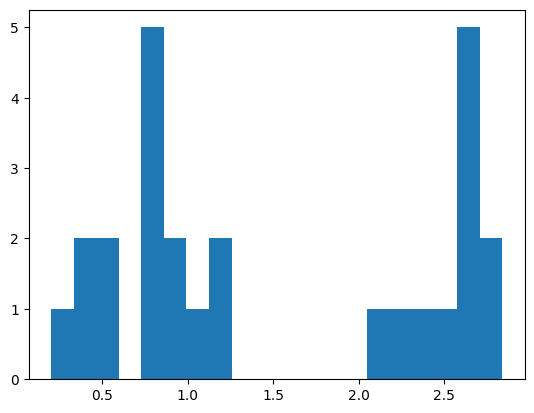

In [20]:
import matplotlib.pyplot as plt
plt.hist(Norms, bins = 20)
plt.show()

In [23]:
len([norm for norm in Norms if norm >=1 ] )

13

In [30]:
#Make average capitalization vector
mean_distinct_lower_upper_vector =  torch.zeros(Z_dim).cuda()
for index in Upper_Lower_distinct_indexes:
    mean_distinct_lower_upper_vector = torch.add( mean_distinct_lower_upper_vector, lower_to_upper_dict[index])

print(mean_distinct_lower_upper_vector)
mean_distinct_lower_upper_vector = mean_distinct_lower_upper_vector/len(Upper_Lower_distinct_indexes)
print(mean_distinct_lower_upper_vector)

tensor([ 4.2202, -1.8399,  3.1680, -7.8220, -4.9963, -0.1423,  3.8954,  1.7211,
        -0.1531, -5.8766], device='cuda:0', grad_fn=<AddBackward0>)
tensor([ 0.3246, -0.1415,  0.2437, -0.6017, -0.3843, -0.0109,  0.2996,  0.1324,
        -0.0118, -0.4520], device='cuda:0', grad_fn=<DivBackward0>)


In [25]:
#Generate dict of the mean number
Number_means = {}

for offset in range(10):
    num_indexes = labels_to_indexes[offset]
    num_mean = mean_latent_space_vector(num_indexes)
    Number_means[offset] = num_mean

    print(offset)
print(Number_means)

/tmp/ipykernel_1025795/2705388341.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


0
1
2
3
4
5
6
7
8
9
{0: tensor([-0.2731, -0.2948,  0.2545,  0.1822,  0.4262,  0.1211,  0.6376, -0.4310,
         0.7739, -1.2287], device='cuda:0', grad_fn=<DivBackward0>), 1: tensor([ 0.0702,  0.3009, -0.0086,  0.4134,  0.7067,  0.1108, -0.0973, -0.2598,
        -0.2323,  1.6920], device='cuda:0', grad_fn=<DivBackward0>), 2: tensor([ 1.4723,  0.2661,  0.2805, -0.4044,  0.0824, -0.1659,  0.2368, -0.6325,
        -1.3759, -0.1048], device='cuda:0', grad_fn=<DivBackward0>), 3: tensor([-0.4123,  0.0420,  1.4925,  0.4160, -0.0469, -0.1949,  0.3203,  0.0063,
        -1.0741, -0.4032], device='cuda:0', grad_fn=<DivBackward0>), 4: tensor([ 0.0022, -0.2533, -1.6269,  0.5975, -0.5334,  0.1050,  0.4124, -0.3482,
         0.5745,  0.2033], device='cuda:0', grad_fn=<DivBackward0>), 5: tensor([-0.4266,  0.8054,  1.4433, -0.5436, -0.2026, -0.2172, -0.3625, -0.1252,
         0.9899,  0.1192], device='cuda:0', grad_fn=<DivBackward0>), 6: tensor([ 0.5091, -0.4740,  0.3864,  0.1569,  0.9969,  0.2266, -1

In [33]:

def generate_mega_image_fractional_composite_mean_vector(fractional_value, file_name, include_numbers):
    Combined_View = torch.empty(0, 1, 28, 28).cuda()
    num_characters = 26
    if include_numbers:
        num_characters = 36
    for offset in range(num_characters):

        letter_index = 10 +offset
        lower_index  = 36 +offset 
        if include_numbers:
            letter_index = offset
            lower_index  = 26 + offset 


        A_indexes = labels_to_indexes[letter_index]
        test_image_A, test_target_A = test_dataset[A_indexes[0]]

        #Shape input into what the network wants
        z = torch.flatten(test_image_A)#.cuda(k
        z = torch.tensor(z)
        z = z.cuda()

        #Map through the model to the latent space and the whole way through
        if letter_index< 10:
            latent_sample = Number_means[letter_index]
        else:
            latent_sample = Lower_means[lower_index] 

        sample = vae.decoder(latent_sample)
        adjusted_latent = torch.add( latent_sample , ( fractional_value * mean_distinct_lower_upper_vector) )
        direct_sample = vae.decoder(adjusted_latent).cuda()

        comb_tensor = torch.cat( (z, sample, direct_sample) ).cuda()
        comb_view = comb_tensor.view(3, 1, 28, 28)

        comb_view = fix_tensor_for_image(comb_view)
        Combined_View = torch.cat((Combined_View, comb_view))

    save_image(Combined_View, './examples/average_figure/ltsp_'+str(Z_dim)+'_'+file_name+'_mega_image_mean_vector.png')

In [34]:
generate_mega_image_fractional_composite_mean_vector(0,'lower_case',True)
generate_mega_image_fractional_composite_mean_vector( 0.5 ,'middle',True)
generate_mega_image_fractional_composite_mean_vector(1,'back_to_upper_from_lower',True)

/tmp/ipykernel_1025795/712455548.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


In [ ]:
def generate_numbers_as_letter_caps(file_name, to_lower):
    Combined_View = torch.empty(0, 1, 28, 28).cuda()

    num_characters = 10 

    for offset in range(26):
        #Add letter at start of sequence to aid in readability
        A_indexes = labels_to_indexes[10+offset]
        test_image_A, test_target_A = test_dataset[A_indexes[0]]
        z = torch.flatten(test_image_A)#.cuda(k
        z = torch.tensor(z)
        z = z.cuda()

        comb_view = z.view(1, 1, 28, 28)

        comb_view = fix_tensor_for_image(comb_view)
        Combined_View = torch.cat((Combined_View, comb_view))



        for number in range(num_characters):

            letter_index = 10 +offset
            lower_index  = 36 +offset 

            Number_indexes = labels_to_indexes[number]
            test_image_A, test_target_A = test_dataset[Number_indexes[0]]

            #Shape input into what the network wants
            z = torch.flatten(test_image_A)#.cuda(k
            z = torch.tensor(z)
            z = z.cuda()

            #use the number latent space values
            latent_sample = Number_means[number]

            sample = vae.decoder(latent_sample)
            #adjust with the vector that goes from lower case to upper for that specific letter
            if to_lower:
                adjusted_latent = torch.add( latent_sample , (-1)*(lower_to_upper_dict[10+offset]) )
            else:
                adjusted_latent = torch.add( latent_sample , (lower_to_upper_dict[10+offset]) )

            direct_sample = vae.decoder(adjusted_latent).cuda()

            comb_tensor = torch.cat( (z, sample, direct_sample) ).cuda()
            comb_view = comb_tensor.view(3, 1, 28, 28)

            comb_view = fix_tensor_for_image(comb_view)
            Combined_View = torch.cat((Combined_View, comb_view))

    save_image(Combined_View, './examples/upper_case_numbers/ltsp_'+str(Z_dim)+'_'+file_name+'_.png', nrow = 31)

In [ ]:
generate_numbers_as_letter_caps('letter_by_letter_to_upper', False)
generate_numbers_as_letter_caps('letter_by_letter_to_lower', True)

/tmp/ipykernel_1025795/3189239840.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/tmp/ipykernel_1025795/3189239840.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
